In [1]:
import sys
sys.path.append('../')
import argparse
from dataset.get_dataset import getDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch

class args_struct:
    def __init__(self):
        self.dataroot = '../../data/DiscRegion/DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = False
        self.random_seed = 27
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

In [2]:
def get_dice_threshold(output, mask, threshold):
    """
    :param output: output shape per image, float, (0,1)
    :param mask: mask shape per image, float, (0,1)
    :param threshold: the threshold to binarize output and feature (0,1)
    :return: dice of threshold t
    """
    smooth = 1e-6

    zero = torch.zeros_like(output)
    one = torch.ones_like(output)
    output = torch.where(output > threshold, one, zero)
    mask = torch.where(mask > threshold, one, zero)
    output = output.view(-1)
    mask = mask.view(-1)
    intersection = (output * mask).sum()
    dice = (2. * intersection + smooth) / (output.sum() + mask.sum() + smooth)

    return dice
def get_soft_dice(outputs, masks):
    """
    :param outputs: B * output shape per image
    :param masks: B * mask shape per image
    :return: average dice of B items
    """
    dice_list = []
    for this_item in range(outputs.size(0)):
        output = outputs[this_item]
        mask = masks[this_item]
        dice_item_thres_list = []
        for thres in [0.1, 0.3, 0.5, 0.7, 0.9]:
            dice_item_thres = get_dice_threshold(output, mask, thres)
            dice_item_thres_list.append(dice_item_thres.data)
        dice_item_thres_mean = np.mean(dice_item_thres_list)
        dice_list.append(dice_item_thres_mean)

    return np.mean(dice_list)

In [3]:
train_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
disc_dices = []
cup_dices =  []
for batch_data in train_loader:
    imgs, masks, file_names = batch_data['image'], batch_data['mask'], batch_data['name']
    
    patient_disc_dices = []
    patient_cup_dices =  []
    for expert_i in range(len(masks)):
        for expert_j in range(expert_i+1, len(masks)):
            patient_disc_dices.append(
                get_soft_dice(masks[expert_i][:, 0, :, :], masks[expert_j][:, 0, :, :])
            )
            patient_cup_dices.append(
                get_soft_dice(masks[expert_i][:, 1, :, :], masks[expert_j][:, 1, :, :])
            )
    
    disc_dices.append(np.mean(patient_disc_dices))
    cup_dices.append(np.mean(patient_cup_dices))

In [4]:
len(disc_dices)

95

In [5]:
len(cup_dices)

95

In [6]:
np.min(cup_dices)

0.40855427674278527

#### Get model preds

In [7]:
from models.unet_le import UNetLE

In [8]:
class args_struct:
    def __init__(self):
        self.dataroot = '../../data/DiscRegion/DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = True
        self.random_seed = 27
        self.loss_func = 'bce'
        self.batch_size = 1
        self.gt_type_train = -1
        self.num_worker = 4

In [9]:
args = args_struct()

args.gt_type_train = -1
args.loss_func = 'bce' 
args.batch_size = 1
args.num_worker = 4
args.use_mix_label = False
args.standardize = True

In [10]:
from trainer.train_riga_unet_le import validate_riga_le
from loss_func.get_loss import get_loss_func

loss_func = get_loss_func(args)

from models.unet_le import UNetLE
model = UNetLE()

In [11]:
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)

In [69]:
model = UNetLE()

path = '/media/kudaibergen/TS512/projects_ts/grader_soup/src/outputs/RIGA_gt_annots_train_majority_vote_UnetLE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
model.load_state_dict(torch.load(path)['model'])

<All keys matched successfully>

In [52]:
validate_riga_le(args, model, valid_set, loss_func, skip_idx=6)

  0%|          | 0/131 [00:00<?, ?it/s]

100%|██████████| 131/131 [00:03<00:00, 33.84it/s]


(0.11717555682057061, 0.965246302480916, 0.822940273139313)

In [53]:
def get_model_outputs(args, model, val_set, loss_function, skip_idx=None):
    model = model.cuda()
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    model.eval()

    outputs_model = []
    masks = []
    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            outputs = model({'image': imgs})

            outputs_sigmoid = []
            if skip_idx is not None:
                outputs = outputs[skip_idx:]

            for i, out in enumerate(outputs):
                out = torch.nn.functional.interpolate(out, size=mask[0].shape[2:])
                outputs_sigmoid.append(torch.sigmoid(out))

        outputs_model.append(outputs_sigmoid)
        masks.append(mask)
    return outputs_model, masks

In [70]:
model_outputs, masks = get_model_outputs(args, model, test_set, loss_func, skip_idx=3)

In [16]:
len(model_outputs)

95

In [17]:
cup_idx = 1
disc_idx = 0

In [18]:
torch.stack(model_outputs[0]).shape

torch.Size([4, 1, 2, 256, 256])

In [19]:
torch.stack(model_outputs[0])[:, :, cup_idx, :, :].shape

torch.Size([4, 1, 256, 256])

In [72]:
outputs_variance_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).sum().cpu().item() for out in model_outputs]
outputs_variance_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).sum().cpu().item() for out in model_outputs]

In [21]:
len(model_outputs)

95

In [22]:
len(masks)

95

In [23]:
torch.special.entr(torch.tensor([0, 1, 0, 1, 0, 1]))

tensor([0., -0., 0., -0., 0., -0.])

In [24]:
np.var([0, 1, 0, 1, 0, 1])

0.25

In [31]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [34]:
rmse_loss = RMSELoss()

In [35]:
var_loss = rmse_loss(torch.stack(variance_heatmap).cuda(), torch.stack(variance_heatmap_output))

In [50]:
torch.log(torch.stack(variance_heatmap).cuda().sum() / torch.stack(variance_heatmap_output).sum())

tensor(2.1391, device='cuda:0', dtype=torch.float64)

In [36]:
var_loss

tensor(0.0425, device='cuda:0', dtype=torch.float64)

In [61]:
np.log(0.6/0.25)

0.8754687373538999

In [28]:
variance_heatmap = [torch.stack(mask).var(dim=0) for mask in masks]
variance_heatmap_output = [torch.stack(out).var(dim=0) for out in model_outputs]

In [45]:
torch.stack(variance_heatmap).mean(), \
torch.stack(variance_heatmap).min(), \
torch.stack(variance_heatmap).max(), \
torch.stack(variance_heatmap).quantile(0.99)

(tensor(0.0087, dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0.3000, dtype=torch.float64),
 tensor(0.2667, dtype=torch.float64))

In [47]:
torch.stack(variance_heatmap_output).mean(), \
torch.stack(variance_heatmap_output).min(), \
torch.stack(variance_heatmap_output).max(), \
torch.stack(variance_heatmap_output).quantile(0.99)

(tensor(0.0028, device='cuda:0'),
 tensor(1.0842e-06, device='cuda:0'),
 tensor(0.1943, device='cuda:0'),
 tensor(0.0632, device='cuda:0'))

In [56]:
mask_variance_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).sum().cpu().item() for out in masks]
mak_variance_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).sum().cpu().item() for out in masks]

In [25]:
len(mask_variance_cup)

95

In [145]:
len(outputs_variance_disc)

95

In [58]:
from scipy.stats import pearsonr, spearmanr

#### with guidance

In [66]:
pearsonr(disc_dices, outputs_variance_disc), \
pearsonr(cup_dices, outputs_variance_cup), \
pearsonr(mak_variance_disc, outputs_variance_disc), \
pearsonr(mask_variance_cup, outputs_variance_cup)

(PearsonRResult(statistic=0.12710576297586812, pvalue=0.21965022423649605),
 PearsonRResult(statistic=-0.10248265343801746, pvalue=0.3230258286383106),
 PearsonRResult(statistic=0.6429801673343135, pvalue=2.1338567100915737e-12),
 PearsonRResult(statistic=0.5116813880540386, pvalue=1.1616364209223886e-07))

In [67]:
spearmanr(disc_dices, outputs_variance_disc), \
spearmanr(cup_dices, outputs_variance_cup), \
spearmanr(mak_variance_disc, outputs_variance_disc), \
spearmanr(mask_variance_cup, outputs_variance_cup)

(SignificanceResult(statistic=0.1132558790593505, pvalue=0.2744865574183468),
 SignificanceResult(statistic=-0.08285274356103024, pvalue=0.42473595088884697),
 SignificanceResult(statistic=0.6614501679731244, pvalue=2.9542735371651196e-13),
 SignificanceResult(statistic=0.6062290033594626, pvalue=7.502882295273199e-11))

In [68]:
distance_correlation(disc_dices, outputs_variance_disc), \
distance_correlation(cup_dices, outputs_variance_cup), \
distance_correlation(mak_variance_disc, outputs_variance_disc), \
distance_correlation(mask_variance_cup, outputs_variance_cup)

(0.15097908214184405,
 0.1588512546898208,
 0.6453996866367888,
 0.6022539166036952)

#### Le random sampling

In [112]:
pearsonr(disc_dices, outputs_variance_disc), \
pearsonr(cup_dices, outputs_variance_cup), \
pearsonr(mak_variance_disc, outputs_variance_disc), \
pearsonr(mask_variance_cup, outputs_variance_cup)

(PearsonRResult(statistic=-0.04256242367406478, pvalue=0.6821426736243122),
 PearsonRResult(statistic=-0.059783091772305896, pvalue=0.564956724816376),
 PearsonRResult(statistic=-0.6404540034898978, pvalue=2.7676260141717426e-12),
 PearsonRResult(statistic=-0.404845005603768, pvalue=4.714293900089688e-05))

In [113]:
spearmanr(disc_dices, outputs_variance_disc), \
spearmanr(cup_dices, outputs_variance_cup), \
spearmanr(mak_variance_disc, outputs_variance_disc), \
spearmanr(mask_variance_cup, outputs_variance_cup)

(SignificanceResult(statistic=-0.0032894736842105266, pvalue=0.9747611683116165),
 SignificanceResult(statistic=-0.08978163493840985, pvalue=0.3869028234783466),
 SignificanceResult(statistic=-0.6617721164613661, pvalue=2.850678439263817e-13),
 SignificanceResult(statistic=-0.5496080627099664, pvalue=8.012350159482334e-09))

In [114]:
distance_correlation(disc_dices, outputs_variance_disc), \
distance_correlation(cup_dices, outputs_variance_cup), \
distance_correlation(mak_variance_disc, outputs_variance_disc), \
distance_correlation(mask_variance_cup, outputs_variance_cup)

(0.15230256283105253,
 0.15809771951310525,
 0.6351015024855868,
 0.537728528410367)

#### Le


In [73]:
pearsonr(disc_dices, outputs_variance_disc), \
pearsonr(cup_dices, outputs_variance_cup), \
pearsonr(mak_variance_disc, outputs_variance_disc), \
pearsonr(mask_variance_cup, outputs_variance_cup)

(PearsonRResult(statistic=-0.0757349845759655, pvalue=0.4657265834474203),
 PearsonRResult(statistic=0.04362535673406012, pvalue=0.6746473975365781),
 PearsonRResult(statistic=-0.2979858151440561, pvalue=0.0033581728985812155),
 PearsonRResult(statistic=-0.30131911596991684, pvalue=0.0030042137430275496))

In [74]:
spearmanr(disc_dices, outputs_variance_disc), \
spearmanr(cup_dices, outputs_variance_cup), \
spearmanr(mak_variance_disc, outputs_variance_disc), \
spearmanr(mask_variance_cup, outputs_variance_cup)

(SignificanceResult(statistic=-0.1076427771556551, pvalue=0.2991288803357056),
 SignificanceResult(statistic=0.07354423292273236, pvalue=0.4787645205080622),
 SignificanceResult(statistic=-0.3247200447928332, pvalue=0.0013248027020331186),
 SignificanceResult(statistic=-0.5451287793952968, pvalue=1.1181005575470863e-08))

In [62]:
from statsmodels.stats.dist_dependence_measures import distance_correlation

In [75]:
distance_correlation(disc_dices, outputs_variance_disc), \
distance_correlation(cup_dices, outputs_variance_cup), \
distance_correlation(mak_variance_disc, outputs_variance_disc), \
distance_correlation(mask_variance_cup, outputs_variance_cup)

(0.18798038685560492,
 0.1395311431720164,
 0.3438271213071308,
 0.48576792321695966)

: 

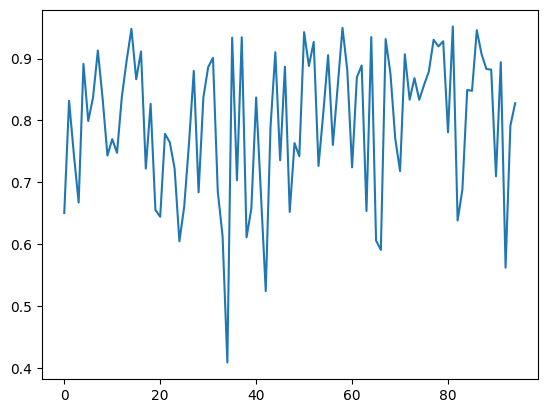

In [150]:
plt.plot(cup_dices)

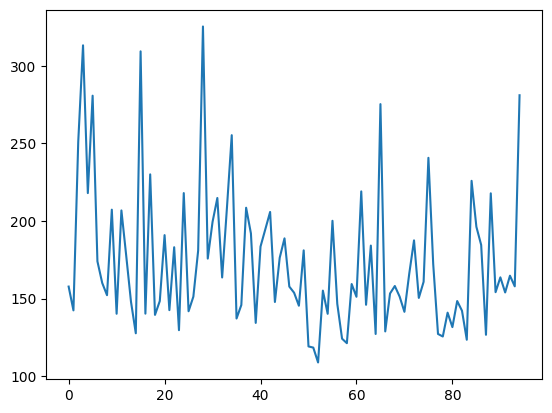

In [151]:
plt.plot(outputs_variance_cup)

#### compare with deep ensembles

In [33]:
checkpoints = [
    f'/home/kudaibergen/projects/grader_soup/outputs/RIGA_gt_annots_train_majority_vote_UnetDE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop{i}/checkpoints/best_loss.pt'
    for i in range(2, 8)
    ]

In [34]:
from models.unet import UNet

In [68]:
models = []
for chk in checkpoints:
    model = UNet()
    model.load_state_dict(torch.load(chk)['model'])
    model.eval()
    model.cuda()
    models.append(model)

In [88]:
val_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

outputs_model = []
for step, data in enumerate(val_loader):
    with torch.no_grad():
        imgs = data['image'].cuda()
        mask = data['mask']

        per_model_outputs = []
        for model in models:
            outputs = model({'image': imgs})
            outputs = torch.sigmoid(outputs['raw'])
            per_model_outputs.append(outputs)

        outputs_model.append(per_model_outputs)

In [89]:
outputs_variance_cup = [torch.stack(out)[:, :, cup_idx, :, :].var(dim=0).sum().cpu().item() for out in outputs_model]
outputs_variance_disc = [torch.stack(out)[:, :, disc_idx, :, :].var(dim=0).sum().cpu().item() for out in outputs_model]

In [38]:
len(outputs_variance_cup)

95

In [71]:
pearsonr(disc_dices, outputs_variance_disc), \
pearsonr(cup_dices, outputs_variance_cup), \
pearsonr(mak_variance_disc, outputs_variance_disc), \
pearsonr(mask_variance_cup, outputs_variance_cup)

(PearsonRResult(statistic=0.007808024585446924, pvalue=0.9401376382040015),
 PearsonRResult(statistic=0.13238158794289617, pvalue=0.20094933500470727),
 PearsonRResult(statistic=0.33620687057197585, pvalue=0.000865085161279506),
 PearsonRResult(statistic=0.41210534757331957, pvalue=3.332062739050576e-05))

In [70]:
spearmanr(disc_dices, outputs_variance_disc), \
spearmanr(cup_dices, outputs_variance_cup), \
spearmanr(mak_variance_disc, outputs_variance_disc), \
spearmanr(mask_variance_cup, outputs_variance_cup)

(SignificanceResult(statistic=-0.08332866741321389, pvalue=0.42207123315036565),
 SignificanceResult(statistic=0.11444568868980963, pvalue=0.26944362467864685),
 SignificanceResult(statistic=0.4728723404255319, pvalue=1.30585103498037e-06),
 SignificanceResult(statistic=0.349426091825308, pvalue=0.0005189462989888927))

In [90]:
distance_correlation(disc_dices, outputs_variance_disc), \
distance_correlation(cup_dices, outputs_variance_cup), \
distance_correlation(mak_variance_disc, outputs_variance_disc), \
distance_correlation(mask_variance_cup, outputs_variance_cup)

(0.188117568070703, 0.1729388158702675, 0.4440356044219752, 0.3995507343316547)